In [1]:
import argparse
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as data
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.signal import savgol_filter

In [2]:
### READ DATA ###
data = pd.read_csv('adult.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [3]:
print(data.shape)
print(data.columns)
print(data[:5])
income = pd.Index([">50K", "<=50K"])
data.income.value_counts()

(48842, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Prote

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [4]:
### DATA CLEANING AND CHECK ###
col_names = data.columns
num_rows = data.shape[0]

for feature in col_names: 
    count = data[feature].isin(["?"]).sum() #sum the "?"s in the column  
#     print("?s in", feature, ":", count)
    

# Get rid of samples with"?"  
    warnings.simplefilter(action='ignore', category=FutureWarning)
    data = data[data[feature] != "?"]
    
data.income.value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [5]:
for feature in col_names: 
    count = data[feature].isin(["?"]).sum() #sum the "?"s in the column  
#     print("?s in", feature, ":", count)
    
categorical_feats = ['workclass', 'race', 'education', 'marital-status', 'occupation',
                    'relationship', 'gender', 'native-country', 'income']

#Check each possible value of a categorical feature and how often it occurs
features = 0
for feature in categorical_feats:
    print("-----",feature,"-----")
    print(data[feature].value_counts()) # No.of each distinct feature/feature column
    
    n = len(pd.unique(data[feature]))
    features += n
    print("There are",n , feature)  
print(features)

----- workclass -----
Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64
There are 7 workclass
----- race -----
White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64
There are 5 race
----- education -----
HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education, dtype: int64
There are 16 education
----- marital-status -----
Married-civ-spouse       21055
Never-married            14598
Divorced                  629

In [6]:
### ENCODE DATA ###
# 1. Encode categorical data, drop the income
label_encoder = LabelEncoder() 
cts_feats = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
cat_data = data.drop(columns = cts_feats)
cat_data_encoded = cat_data.apply(label_encoder.fit_transform)
labels = cat_data_encoded['income'].values.reshape(45222, 1)  # labels in columns
cat_data_encoded = cat_data_encoded.drop(columns = 'income')



one_hot_encoder = OneHotEncoder()
cat_one_hot = one_hot_encoder.fit(cat_data_encoded.values)
cat_one_hot = one_hot_encoder.transform(cat_data_encoded.values).toarray() #98 features


# 2. Normalize continuous data
cts_data = data.drop(columns=categorical_feats)
cts_mean = cts_data.mean(axis = 0)
cts_std = cts_data.std(axis = 0)
cts_data = cts_data.sub(cts_mean,axis=1)
cts_data = cts_data.div(cts_std,axis=1)

X = np.concatenate([cts_data, cat_one_hot, labels], axis = 1) 
# Now we get data X with income as the last coloumn
# Now slpit the female and male//column 56+6 is male
X_male = X[X[:,62] == 1] #30527/104
X_female = X[X[:,62] == 0] #14695/104
print(X_male.shape)


(30527, 105)


In [7]:
# Define the architecture of the network 
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1 = nn.Linear(104, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.relu(self.fc4(x))
        

In [8]:
# Define Adult Dataset class 
class AdultDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        # generates one sample of data
        return torch.from_numpy(self.X[index]),self.y[index]

In [9]:
def evaluate(model, val_loader):
    model.eval()
    total_corr = 0
    for i,data in enumerate(val_loader):
        inputs,labels = data
        y_pred = model(inputs.float())
        for i in range (len(labels)):
            if (y_pred[i].item() > 0.5):
                r = 1
            else:
                r = 0
            if (r == labels[i].item()):
                total_corr += 1

    return float(total_corr)/len(val_loader.dataset)

# def accuracy(prediction,label):
#     total_corr = 0
#     prediction = prediction.reshape((len(prediction),))
#     label = list(label)
#     for i in range (len(prediction)):
# #         step = prediction[i] > 0.5 ? 1: 0
#         if (step == label[i]):
#             total_corr += 1
#     return (total_corr/len(label))

def count_num_corr_predicts(prediction,label):
    total_corr = 0
    prediction = prediction.reshape((len(prediction),))
    label = list(label)
    for i in range (len(prediction)):
        if (prediction[i] == label[i]):
             total_corr += 1
    return total_corr

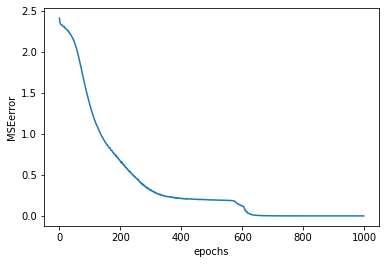

In [10]:
# Define the parameters and specify the loss function and optimizer|binary cross entrophy and Adam optimizer
bs = 10 #batch size
lr = 0.01 #learning rate 
epochs = 1000
N = 10 #print accuracy after N batches

np.random.shuffle(X)
sample_train = X[:120] #0-119// 120 train samples
sample_test = X[120:160] #120-159// 40 test samples

train_X = sample_train[:,:104]
train_y = sample_train[:,104:105]

test_X = sample_test[:,:104]
test_y = sample_test[:,104]


train_data = AdultDataset(train_X, train_y)
test_data = AdultDataset(test_X, test_y)
train_loader = DataLoader(dataset=train_data,batch_size=bs,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=bs,shuffle=True)


model = net()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr)
model.train()

loss_list = []

for epoch in range(epochs):
        running_loss = 0
        
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data.float())
            loss = criterion(output.float(), target.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
#         print('Epoch: {} \tTraining Loss: {:.6f}'.format(
#         epoch+1, 
#         running_loss
#         ))
        loss_list.append(running_loss)
plt.plot(loss_list)
plt.xlabel('epochs')
plt.ylabel('MSEerror')
plt.show()

In [11]:
#split the data into 4096 trainsets and 1 testset